# Bank Marketing Analytics: Bank Marketing Campaign for Term Deposits
### Created By : Fransiska Sri Mayawi

## Business Problem Understanding

## Business Problem

Bank menghadapi tantangan dalam memasarkan produk **deposito berjangka** secara efektif.  
**Urgensi Produk Deposito bagi Bank :**
- Sumber utama Dana Pihak Ketiga (DPK) → menjaga likuiditas & stabilitas keuangan.
- Biaya dana lebih murah → tingkatkan profitabilitas (spread bunga).  
- Mendukung penyaluran kredit sebagai core business.
- Tingkatkan retensi & loyalitas nasabah (dana terikat jangka waktu tertentu).  


**Strategi Pemasaran Saat Ini:**
- **Target All** → Menghubungi semua nasabah.  
  - Biaya kampanye tinggi, mayoritas nasabah tidak tertarik.  
- **Target None** → Tidak menghubungi nasabah sama sekali.  
  - Risiko kehilangan peluang dari nasabah potensial.  


**Inefisiensi Biaya** 

Kedua strategi tersebut belum efisien:
- **Target All** → Pemborosan (lebih dari separuh nasabah tidak melakukan deposito), Biaya kampanye membengkak karena menargetkan nasabah yang sebenarnya tidak tertarik membuka deposito.
- **Target None** → Kerugian lebih besar (potensi deposito dari nasabah berminat terlewat). Kehilangan peluang dari nasabah yang sebenarnya berminat membuka deposito.


### **Tujuan**
Membangun model Machine Learning untuk **memprediksi nasabah yang kemungkinan akan membuka deposito**, sehingga Bank dapat:
- Menargetkan kampanye hanya kepada nasabah yang berpotensi tinggi.
- Mengoptimalkan anggaran pemasaran.
- Mengurangi biaya total (promosi + kehilangan peluang).



### **Definisi Target (Deposit)**
- **0** = Tidak Deposito.
- **1** = Deposito.



### **Sebelum Menggunakan Machine Learning**
Berdasarkan confusion matrix dari **kondisi sebelum menggunakan model ML**:

![Alt text](CM_Before_ML_dfclean.png)

- **Total pelanggan** = 1551
- **Total deposito sebenarnya (yes)** = 741
- **Total tidak deposito (no)** = 810



### **Asumsi Biaya**
- **Campaign cost (C)** = USD 10 / nasabah yang dihubungi.
- **Lost opportunity cost (L)** = USD 150 / nasabah potensial yang tidak dihubungi.



### **Perhitungan Biaya Baseline**

**Skenario 1 — Target All**
- Biaya campaign = 1551 × USD 10 = **USD 15.510**
- Biaya campaign yang diperlukan sebenarnya = 741 x USD 10 = **USD 7.410**
- **Total biaya kerugian Bank untuk campaign yang tidak perlu = USD 8.100**

**Skenario 2 — Target None**
- Biaya lost opportunity = 741 × USD 150 = **USD 111.150**
- **Total biaya = USD 111.150**

### **Insight dari Baseline**
- **Target None** jauh lebih mahal dibandingkan **Target All** karena biaya *lost opportunity* (USD 111,150) jauh lebih tinggi daripada biaya kampanye (USD 15,510).  
- **Target All** tetap tidak efisien karena 810 dari 1,551 kontak (~52,2%) tidak menghasilkan deposito → pemborosan biaya kampanye sebesar USD 8,100.  

### **Metrics Selection**
- Karena **Lost Opportunity (L = USD 150)** jauh lebih besar dibandingkan **Campaign Cost (C = USD 10)**, maka menghindari **False Negatives (FN)** jauh lebih penting dibandingkan menghindari False Positives (FP).  
- Metrik evaluasi yang sesuai: **Fβ-Score dengan β > 1** (misalnya **F2 atau F3**) yang lebih menekankan **recall** (mengurangi FN) dibandingkan precision.  


---

## Data Understanding & Data Cleaning

### Attribute Information

| Attribute   | Data Type         | Description                                                                 |
|-------------|-------------------|-----------------------------------------------------------------------------|
| age         | Integer           | Usia nasabah                                                                |
| job         | Object (Text)| Jenis pekerjaan nasabah (misalnya: technician, unemployed, dll)                 |
| balance     | Integer           | Saldo rekening nasabah dalam USD                                           |
| housing     | Binary (yes/no)   | Apakah nasabah memiliki pinjaman rumah                                     |
| loan        | Binary (yes/no)   | Apakah nasabah memiliki pinjaman pribadi                                   |
| contact     | Categorical (Text)| Jenis komunikasi yang digunakan untuk menghubungi nasabah                  |
| month       | Categorical (Text)| Bulan terakhir saat nasabah dihubungi dalam kampanye                       |
| campaign    | Integer           | Jumlah kontak yang dilakukan selama kampanye ini kepada nasabah            |
| pdays       | Integer           | Jumlah hari sejak terakhir kali nasabah dihubungi pada kampanye sebelumnya |
| poutcome    | Categorical (Text)| Hasil dari kampanye pemasaran sebelumnya                                   |
| deposit     | Binary (yes/no)   | Apakah nasabah akhirnya membuka deposito atau tidak (target)               |


Dataset source : https://drive.google.com/drive/folders/13lrEDlKfnTPNREfGLBaYGYf8dSjHBzfW

**Note :**

- **Setiap baris data merepresentasikan satu nasabah**  
  Data mencakup informasi profil nasabah, status keuangan, dan riwayat interaksi kampanye pemasaran bank terkait penawaran **deposito berjangka**.

- **Fitur numerik**  
  - `age`: Usia nasabah
  - `balance`: Saldo tabungan nasabah
  - `campaign`: Jumlah kontak yang dilakukan selama kampanye saat ini
  - `pdays`: Jumlah hari sejak nasabah terakhir dihubungi dalam kampanye sebelumnya (`-1` berarti belum pernah dihubungi)

- **Fitur kategorikal**  
  Beberapa fitur seperti `job`, `housing`, `loan`, `contact`, `month`, dan `poutcome` merupakan fitur kategorikal. Beberapa fitur memiliki **kardinalitas tinggi**, seperti `job` dan `month` masing-masing memiliki 12 kategori unik.

> Catatan: Fitur `job`, `contact`, `poutcome` memiliki nilai `'unknown'` yang berarti ada pekerjaan, jenis komunikasi, serta hasil dari campaign yang tidak tercatat atau tidak diketahui secara pasti. Hal ini perlu dipertimbangkan dalam preprocessing.


In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import BinaryEncoder

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from xgboost import XGBClassifier
# import lightgbm as lgb
# from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
# # from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# # Imbalance Dataset
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("data_bank_marketing_campaign.csv")
df.tail()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no
7812,60,retired,1588,no,no,cellular,oct,1,-1,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


---

Dataset ini tidak memiliki nilai kosong (null) pada seluruh kolom, namun tetap memerlukan beberapa proses pembersihan dan penyesuaian sebelum digunakan untuk analisis dan pembuatan model machine learning.

Beberapa langkah pembersihan data yang dilakukan antara lain:

- **Memastikan tipe data sudah sesuai**
Kolom numerik (`age`, `balance`, `campaign`, `pdays`) memiliki tipe data numerik dan kolom lainnya bertipe kategori atau teks sesuai maknanya.

- **Menstandarkan kategori** 
Pada fitur bertipe kategori seperti `job`, `contact`, `month`, `poutcome`, tidak ada perbedaan penulisan atau kapitalisasi yang dapat mengganggu proses analisis.

- **Mengonversi label target `deposit`** 
Dari teks (`yes`/`no`) menjadi format numerik (`1` untuk `yes`, `0` untuk `no`) agar dapat digunakan dalam algoritma klasifikasi.

- **Memeriksa nilai-nilai anomali atau outlier**
khususnya pada fitur numerik seperti `balance` dan `campaign`, yang mungkin dapat memengaruhi performa model.

Dengan pembersihan ini, dataset akan menjadi lebih konsisten, siap digunakan untuk eksplorasi data lebih lanjut, dan cocok untuk pelatihan model machine learning.


In [4]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[no, yes]"
4,loan,2,"[no, yes]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


--- 
### Cek Missing Value

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[45, 65]"
1,job,object,0,0.0,12,"[technician, entrepreneur]"
2,balance,int64,0,0.0,3153,"[5511, 363]"
3,housing,object,0,0.0,2,"[no, yes]"
4,loan,object,0,0.0,2,"[yes, no]"
5,contact,object,0,0.0,3,"[cellular, unknown]"
6,month,object,0,0.0,12,"[jan, mar]"
7,campaign,int64,0,0.0,32,"[14, 13]"
8,pdays,int64,0,0.0,422,"[156, 202]"
9,poutcome,object,0,0.0,4,"[other, success]"


- Tidak terdapat nilai null pada setiap kolom. Tidak perlu melakukan penangan missing value.

---
### Data Duplicate

In [6]:
#Lanjut cek data duplicate
df.duplicated().sum()

np.int64(8)

In [7]:
df[df.duplicated(keep=False)]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
223,38,technician,0,no,no,cellular,aug,2,-1,unknown,no
330,40,blue-collar,0,yes,no,unknown,may,2,-1,unknown,no
1381,39,technician,0,yes,no,unknown,may,1,-1,unknown,no
1468,34,management,0,no,no,cellular,aug,2,-1,unknown,no
1948,60,management,0,no,no,cellular,aug,3,-1,unknown,yes
2486,30,blue-collar,239,yes,no,unknown,may,1,-1,unknown,yes
2944,40,blue-collar,0,yes,no,unknown,may,2,-1,unknown,no
3073,41,management,0,no,no,cellular,aug,2,-1,unknown,no
4368,60,management,0,no,no,cellular,aug,3,-1,unknown,yes
4874,41,management,0,no,no,cellular,aug,2,-1,unknown,no


In [8]:
df.drop_duplicates(inplace=True)

- Ditemukan ada 8 data duplicate, maka dilakukan drop baris duplicate.
- Sehingga dari semula jumlah baris 7813 menjadi 7805.

---
### Identify Outlier & Data Distribution

In [9]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pilih kolom numerik selain target
num_cols = df.select_dtypes(include='number').drop(columns=['deposit'], errors='ignore').columns.tolist()

# Tentukan jumlah baris dan kolom subplot
rows = (len(num_cols) + 1) // 2  # 2 kolom layout
cols = 2

# Buat subplots
fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f"{col} VS deposit" for col in num_cols]
)

# Loop untuk setiap kolom numerik
for i, col in enumerate(num_cols):
    row = i // cols + 1
    col_num = i % cols + 1
    
    # Buat plot dengan px.box
    box_fig = px.box(df, x="deposit", y=col, color="deposit")
    
    # Masukkan trace ke subplot
    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col_num)

# Layout
fig.update_layout(
    height=350 * rows,
    width=900,
    title_text="Semua Variabel Numerik berdasarkan Deposit",
    showlegend=False
)

fig.show()

**Interpretasi :**
1. Age vs Deposit
- Sebaran umur mirip, tetapi ada sedikit lebih banyak nasabah berusia lebih tua di kelompok yes.
- Outlier umur > 80 tahun ada di kedua kelompok, namun jumlahnya kecil. 
- Outlier pada usia diabaikan karena masih wajar, banyak penabung di usia tua yang menabung di deposito karena merupakan salah satu pasif income yang aman dan mudah.

2. Balance vs Deposit
- Distribusi balance sangat skewed (banyak outlier sangat tinggi di kedua grup).
- Median saldo bagi “yes” sedikit lebih tinggi dari “no”, namun perbedaannya tidak terlalu besar.
- Outlier ekstrem (saldo sangat tinggi) lebih banyak di grup “no”, kemungkinan karena beberapa nasabah dengan balance yang tinggi tidak tertarik pada produk deposito.

3. Campaign vs Deposit
- Median campaign (jumlah kontak selama kampanye) bagi “yes” sedikit lebih rendah dibanding “no”.
- Grup “no” punya lebih banyak outlier ekstrem (campaign > 20 kali). Ini bisa menandakan bahwa terlalu sering menghubungi nasabah justru menurunkan peluang untuk menarik nasabah melakukan pembukaan rekening deposito.

4. Pdays vs Deposit
- Pdays adalah jumlah hari sejak terakhir kali dihubungi dalam kampanye sebelumnya.
- Grup “yes” cenderung memiliki pdays lebih rendah (lebih cepat dihubungi kembali) dibanding “no”.
- Grup “no” didominasi nilai pdays = 999 (tidak pernah dihubungi sebelumnya), yang bisa menjelaskan rendahnya konversi.


**Insight utama:**

Usia sedikit lebih tua, saldo cukup, jumlah kontak wajar (tidak berlebihan), dan interaksi yang lebih cepat setelah kampanye sebelumnya tampaknya berhubungan dengan kemungkinan nasabah membuka deposito.

In [10]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations

# Warna custom
color_discrete_map = {'yes': 'blue', 'no': 'gray'}

# Daftar variabel numerik
numeric_cols = ['age', 'balance', 'campaign', 'pdays']

# Buat semua kombinasi unik pasangan variabel
var_pairs = list(combinations(numeric_cols, 2))

# Tentukan jumlah baris dan kolom subplot
rows = (len(var_pairs) + 1) // 2
cols = 2

# Buat subplots
fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f"{x} vs {y}" for x, y in var_pairs]
)

# Loop dan tambahkan setiap scatter plot ke subplot
for i, (x, y) in enumerate(var_pairs):
    row = i // cols + 1
    col_num = i % cols + 1
    
    scatter_fig = px.scatter(
        df, x=x, y=y, color='deposit', opacity=0.6,
        color_discrete_map=color_discrete_map  # <-- tambahkan ini
    )
    
    # Tambahkan trace dari px.scatter ke subplot
    for trace in scatter_fig.data:
        fig.add_trace(trace, row=row, col=col_num)

# Layout
fig.update_layout(
    height=400 * rows,
    width=900,
    title_text="Scatter Plot Variabel Numerik dengan Hue = Deposit",
    showlegend=False
)

fig.show()


**Insight :**

1. Age vs Balance

- Titik menyebar luas, tanpa pola korelasi yang jelas antara umur dan saldo.
- Nasabah dengan saldo sangat tinggi (>20k) tetap ada di semua kelompok umur, tapi tidak terlihat dominasi “yes” di saldo tinggi. Artinya, saldo besar tidak menjamin nasabah mau membuka deposito.

2. Age vs Campaign
- Mayoritas nasabah memiliki jumlah kontak (campaign) rendah (<10) di semua umur.
- Tidak ada hubungan jelas antara umur dan banyaknya campaign.
- Nasabah yang deposito cenderung lebih banyak muncul di area campaign rendah, mendukung insight bahwa terlalu sering menghubungi malah kurang efektif.

3. Age vs Pdays
- Titik menumpuk di pdays = -1 (belum pernah dihubungi).
- “Yes” cenderung muncul di pdays rendah, artinya konversi lebih tinggi jika contact dilakukan segera setelah campaign sebelumnya.

4. Balance vs Campaign
- Sebagian besar nasabah punya saldo rendah (<5k) dan jumlah campaign kecil (<10).
- “Yes” terlihat lebih banyak pada kombinasi saldo rendah-menengah dan campaign rendah.
- Tidak ada bukti bahwa nasabah bersaldo tinggi membutuhkan lebih banyak campaign untuk deposito.

5. Balance vs Pdays
- Titik menumpuk pada pdays rendah dan saldo rendah.
- “Yes” relatif lebih banyak di kelompok pdays rendah terlepas dari saldo, lagi-lagi menunjukkan efek kecepatan kontak.

6. Campaign vs Pdays
- Sebagian besar data terkonsentrasi di campaign rendah dan pdays rendah.
- “Yes” terlihat menumpuk di wilayah ini, artinya interaksi cepat dan tidak terlalu sering menghubungi tetap menjadi pola yang efektif.

**Kesimpulan Utama :**

Tidak ada korelasi linear kuat antara variabel-variabel ini, tapi pola distribusi menunjukkan:
- Campaign rendah + pdays rendah → peluang deposit lebih besar.
- Saldo tinggi tidak menjamin konversi.
- Usia tidak terlalu memengaruhi konversi jika dibandingkan dengan faktor waktu campaign (pdays) dan frekuensi campaign.

In [11]:
categorical_cols = ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Buat subplot grid: 2 kolom, baris otomatis
rows = (len(categorical_cols) + 1) // 2
fig = make_subplots(
    rows=rows, cols=2,
    subplot_titles=[f"{col.capitalize()} vs Deposit" for col in categorical_cols]
)

row, col_num = 1, 1
for cat in categorical_cols:
    # Hitung jumlah per kategori & deposit
    group = df.groupby([cat, 'deposit']).size().reset_index(name='Count')
    
    # Hitung proporsi per kategori
    group['Proportion'] = group.groupby(cat)['Count'].transform(lambda x: x / x.sum())
    
    # Buat barplot Count, tapi label text = Proportion (%)
    bar = px.bar(
        group,
        x=cat,
        y='Count',  # Y = jumlah asli
        color='deposit',
        barmode='group',
        text=group['Proportion'].apply(lambda p: f"{p:.1%}"),  # Label = persentase
        color_discrete_map=color_discrete_map
    )
    
    # Tambahkan trace ke subplot
    for trace in bar.data:
        fig.add_trace(trace, row=row, col=col_num)
    
    # Update posisi subplot
    col_num += 1
    if col_num > 2:
        col_num = 1
        row += 1

fig.update_layout(
    height=rows * 400,
    width=1000,
    title_text="Jumlah Variabel Kategorik terhadap Deposit (Label = Proporsi)",
    showlegend=True
)

fig.show()


**Interpretasi :**
1. Job vs Deposit
- Profesi retired (pensiunan) memiliki proporsi tertinggi yang berdeposit (“yes”), terlihat dari batang biru yang relatif besar.
- Profesi student, unemployed, dan management juga memiliki proporsi cukup tinggi membuka deposito.
- Profesi blue-collar dan services cenderung memiliki proporsi lebih rendah untuk membuka deposito.
Insight: Segmen pekerjaan tertentu (retired, student, management) lebih potensial untuk kampanye deposito.

2. Housing vs Deposit
- Nasabah tanpa kredit rumah (“no”) punya peluang lebih besar untuk membuka deposito (57.7%) dibanding yang memiliki kredit rumah (36.6%). Artinya, beban kedit rumah mungkin mengurangi kecenderungan untuk menyimpan uang dalam bentuk deposito.

3. Loan vs Deposit
- Nasabah tanpa kredit pribadi (“no”) memiliki proporsi jauh lebih tinggi membuka deposito (50.1%) dibanding yang punya kredit pribadi (32.2%).
- Beban utang pribadi tampaknya menurunkan minat atau kemampuan membuka deposito.

4. Contact vs Deposit
- Metode kontak cellular memiliki tingkat keberhasilan tertinggi (55.1%) dibanding telephone (49.5%) dan unknown (22.1%).
- Unknown (contact) punya peluang konversi sangat rendah, mungkin karena data kontak tidak lengkap atau tidak valid.

5. Month vs Deposit
- Bulan April, September, dan December memiliki proporsi “yes” tertinggi (sekitar 60% atau lebih).
- Bulan May justru memiliki volume kampanye paling besar, tapi proporsi “yes” rendah (31.4%). Ini menandakan tingginya aktivitas kampanye tidak selalu berarti tingkat konversi tinggi.
- Bulan-bulan seperti March, October, November memiliki proporsi moderat (sekitar 40–50%).

6. Poutcome vs Deposit (Outcome kampanye sebelumnya)
- Success pada kampanye sebelumnya → tingkat konversi sangat tinggi (91.5%), artinya nasabah yang pernah berhasil dikonversi sebelumnya sangat potensial.
- Other → tingkat konversi cukup tinggi (58.7%), masih di atas rata-rata.
- Failure → proporsinya hampir seimbang (51.3%), berarti kegagalan sebelumnya tidak terlalu menurunkan peluang.
- Unknown → konversi terendah (40.8%), kemungkinan karena minimnya riwayat interaksi.


Insight utama:
- Segmen pekerjaan tertentu lebih responsif terhadap penawaran deposito (retired, student, management).
- Nasabah tanpa beban pinjaman rumah atau pribadi lebih mungkin membuka deposito.
- Channel kontak cellular lebih efektif dibanding telephone atau data kontak yang tidak jelas.
- Campaign sebaiknya difokuskan pada bulan-bulan dengan riwayat konversi tinggi (April, September, December). Waktu Campaign sangat memengaruhi keberhasilan. Ada bulan-bulan “prime” (April, September, December) di mana nasabah lebih responsif.
- Data hasil campaign sebelumnya (poutcome) adalah prediktor kuat, terutama jika pernah sukses sebelumnya → peluang konversi sangat tinggi.



In [12]:
unknown_summary = (
    df.select_dtypes(include='object')
    .apply(lambda col: (col == 'unknown').sum())
    .to_frame(name='unknown_count')
)

unknown_summary['unknown_pct'] = (unknown_summary['unknown_count'] / len(df)) * 100
unknown_summary = unknown_summary[unknown_summary['unknown_count'] > 0]
unknown_summary.sort_values(by='unknown_pct', ascending=False, inplace=True)

unknown_summary

,unknown_count,unknown_pct
poutcome,5811,74.452274
contact,1636,20.960922
job,54,0.691864


In [13]:
df[df['job'] == 'unknown'].shape

(54, 11)

#### Penanganan Data dengan nilai "Unknown"

Beberapa kolom dalam dataset mengandung nilai `"unknown"`, yang bisa dianggap sebagai _missing values tersembunyi_. Nilai ini perlu ditangani sesuai konteks masing-masing kolom.

**Kolom yang Mengandung Nilai "unknown" dan Strategi Penanganannya:**

- Kolom `job` memiliki **54 baris** dengan nilai `"unknown"` (sekitar **0.69%** dari total data). Karena jumlahnya sangat sedikit, baris-baris ini akan **dihapus** dari dataset untuk menjaga kualitas data.

- Kolom `contact` memiliki sekitar **1.639 baris** (sekitar **21%**) dengan nilai `"unknown"`. Karena proporsinya cukup besar, maka nilai `"unknown"` akan **dipertahankan sebagai kategori tersendiri** dalam model.

- Kolom `poutcome` mengandung **5.819 baris** (sekitar **74.5%**) dengan nilai `"unknown"`. Dengan proporsi sebesar ini, data tetap dianggap sebagai **kategori eksplisit**, karena penghapusan akan membuang sebagian besar data.


**Penjelasan Strategi:**

- `job`: Dihapus karena hanya sebagian kecil data yang terdampak. dan data Job sendiri pada Bank merupakan salah satu data mandatory yang cukup penting dan tidak boleh sembarang input, karena harus sesuai dengan status pekerjaan nasabah yang sesungguhnya dan dapat di verifikasi kebenarannya.
- **`contact`** & **`poutcome`**: Dipertahankan karena representasinya signifikan dan bisa mengandung informasi penting bagi model. Unknown pada Contact sendiri bisa jadi merepresentasikan cara lainnya pihak bank dalam melakukan approach kepada nasabah, mungkin dengan melakukan kunjungan langsung, ataupun dengan kirim pesan via Email ataupun WA.


**Keputusan Penanganan**

Baris dengan `job == "unknown"` **lebih baik dihapus** karena:

- Proporsi sangat kecil terhadap data keseluruhan.
- Banyak kolom lain yang juga tidak memiliki informasi bermakna.
- Menghapusnya membantu meningkatkan kebersihan dan kualitas data untuk modeling.

In [14]:
# #Hapus baris dengan nilai Unknwon pada kolom job
df.drop(df[df['job'] == 'unknown'].index, inplace=True)

In [15]:
# Lihat jumlah baris setelah di drop
df.shape

(7751, 11)

In [16]:
df.to_csv("data_bank_marketing_campaign_clean.csv", index=False)

---
## Define X & y

In [17]:
X = df.drop(columns=('deposit'))
y = df['deposit'].map({'yes': 1, 'no': 0})


---
## Data Splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

---
## Data Preparation

In [19]:
df.describe(include='object')

,job,housing,loan,contact,month,poutcome,deposit
count,7751,7751,7751,7751,7751,7751,7751
unique,11,2,2,3,12,4,2
top,management,no,no,cellular,may,unknown,no
freq,1789,4084,6729,5587,1969,5771,4047


In [20]:
df.describe()

,age,balance,campaign,pdays
count,7751.000000,7751.000000,7751.000000,7751.000000
mean,41.210812,1510.083602,2.517095,51.453748
std,11.906602,3085.165104,2.724405,107.981876
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,128.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.500000,3.000000,40.500000
max,95.000000,66653.000000,63.000000,854.000000


#### **Imblance Check**



In [21]:
(df['deposit'] == 'no').sum()


np.int64(4047)

In [22]:
(df['deposit'] == 'yes').sum()

np.int64(3704)

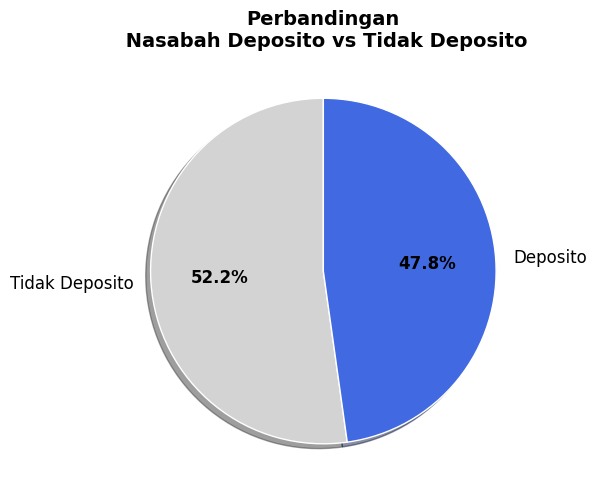

In [23]:
labels = ['Tidak Deposito', 'Deposito']
values = [4047, 3704]
colors = ['lightgrey', 'royalblue'] 
# Pie chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'white'}
)

# Style teks
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

plt.title('Perbandingan\n Nasabah Deposito vs Tidak Deposito', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Dari total 7.751 nasabah, terdapat 4.047 (52,2%) nasabah tidak deposito dan 3.704 (47,8%) nasabah deposito.
Distribusi kelas nasabah deposito dan tidak deposito berada pada proporsi 52,2% : 47,8%. Perbedaan ini tergolong kecil, sehingga data dapat dikatakan relatif seimbang (tidak imbalanced) dan tidak memerlukan penanganan khusus terkait Imbalanced Class.


---
### Data Preprocessing

- Binary Encoding : job
- Ordinal Encoding : month
- One Hot Encoding : housing, loan, contact, poutcome, deposit
- Robust Scaling : age, balance, campaign, pdays

In [24]:
transformer = ColumnTransformer([
    ('binary', BinaryEncoder(), ['job']),
    ('ordinal', OrdinalEncoder(), ['month']),
    ('onehot', OneHotEncoder(drop='first'), ['housing', 'loan', 'contact', 'poutcome']),
    ('robust', RobustScaler(), ['age', 'balance', 'campaign', 'pdays'])
], remainder= 'passthrough')

In [25]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary', BinaryEncoder(), ['job']),
                                ('ordinal', OrdinalEncoder(), ['month']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['housing', 'loan', 'contact', 'poutcome']),
                                ('robust', RobustScaler(),
                                 ['age', 'balance', 'campaign', 'pdays'])])

---
### **Cek Multicolinearity**

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['Acceptable'] = np.where(vif.VIF < 4, 'Yes', 'No') 
    return (vif) 

In [27]:
X

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown
2,51,admin.,3025,no,no,cellular,may,1,352,other
3,38,services,-87,yes,no,cellular,may,1,-1,unknown
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown
...,...,...,...,...,...,...,...,...,...,...
7807,33,management,0,yes,yes,cellular,may,2,-1,unknown
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown


In [28]:
X_transform = transformer.fit_transform(X)
X_transform

array([[ 0.        ,  0.        ,  0.        , ...,  0.71506585,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ..., -2.31737873,
         0.5       ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.59074847,
        -0.5       ,  8.5060241 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  3.16350787,
         0.        ,  4.45783133],
       [ 0.        ,  0.        ,  0.        , ..., -0.3180212 ,
        -0.5       ,  0.        ],
       [ 1.        ,  0.        ,  1.        , ...,  0.66752329,
        -0.5       ,  0.        ]], shape=(7751, 16))

In [29]:
feature_names = transformer.get_feature_names_out()
df_transformed = pd.DataFrame(X_transform, columns=feature_names)
df_transformed.corr()

,binary__job_0,binary__job_1,binary__job_2,binary__job_3,ordinal__month,onehot__housing_yes,onehot__loan_yes,onehot__contact_telephone,onehot__contact_unknown,onehot__poutcome_other,onehot__poutcome_success,onehot__poutcome_unknown,robust__age,robust__balance,robust__campaign,robust__pdays
binary__job_0,1.000000,-0.603233,-0.202103,-0.347770,0.050981,0.036856,0.019678,0.085278,0.082948,-0.014981,-0.011676,0.037191,0.264515,0.001002,-0.021332,-0.027947
binary__job_1,-0.603233,1.000000,0.172400,-0.052251,-0.094847,-0.115824,-0.064869,-0.057879,-0.104369,0.024700,0.026810,-0.032464,-0.164468,0.040561,0.030305,0.004064
binary__job_2,-0.202103,0.172400,1.000000,-0.311004,-0.042156,-0.174382,-0.086344,0.029282,-0.111138,0.015550,0.085319,-0.063179,0.112739,0.047485,-0.019030,0.027617
binary__job_3,-0.347770,-0.052251,-0.311004,1.000000,0.010464,0.029910,0.029313,-0.047894,-0.014149,-0.009000,-0.012793,-0.003881,-0.213310,-0.044960,-0.002401,0.017134
ordinal__month,0.050981,-0.094847,-0.042156,0.010464,1.000000,0.208154,0.027755,0.029473,0.288691,0.004792,0.031657,-0.046404,-0.022595,0.006685,-0.103959,0.027209
onehot__housing_yes,0.036856,-0.115824,-0.174382,0.029910,0.208154,1.000000,0.092791,-0.081054,0.252352,0.008155,-0.141890,0.033026,-0.165907,-0.081582,0.005389,0.054740
onehot__loan_yes,0.019678,-0.064869,-0.086344,0.029313,0.027755,0.092791,1.000000,-0.014540,0.022788,-0.025912,-0.084181,0.061268,-0.023459,-0.088394,0.034508,-0.030276
onehot__contact_telephone,0.085278,-0.057879,0.029282,-0.047894,0.029473,-0.081054,-0.014540,1.000000,-0.140543,0.007902,0.006622,-0.000091,0.200016,0.041579,0.052608,0.000126
onehot__contact_unknown,0.082948,-0.104369,-0.111138,-0.014149,0.288691,0.252352,0.022788,-0.140543,1.000000,-0.109138,-0.163924,0.290411,-0.035015,-0.065849,0.047107,-0.229835
onehot__poutcome_other,-0.014981,0.024700,0.015550,-0.009000,0.004792,0.008155,-0.025912,0.007902,-0.109138,1.000000,-0.075049,-0.390308,-0.025694,0.015192,-0.025521,0.357448


In [30]:
calc_vif(df_transformed)

,variables,VIF,Acceptable
0,binary__job_0,2.755829,Yes
1,binary__job_1,2.811950,Yes
2,binary__job_2,2.306117,Yes
3,binary__job_3,2.487581,Yes
4,ordinal__month,4.165423,No
5,onehot__housing_yes,2.234966,Yes
6,onehot__loan_yes,1.180567,Yes
7,onehot__contact_telephone,1.161124,Yes
8,onehot__contact_unknown,1.652264,Yes
9,onehot__poutcome_other,1.342187,Yes


In [31]:
calc_vif(df_transformed.drop(columns=['onehot__poutcome_unknown']))

,variables,VIF,Acceptable
0,binary__job_0,1.815718,Yes
1,binary__job_1,2.025768,Yes
2,binary__job_2,1.873065,Yes
3,binary__job_3,1.730008,Yes
4,ordinal__month,3.964127,Yes
5,onehot__housing_yes,2.136698,Yes
6,onehot__loan_yes,1.166837,Yes
7,onehot__contact_telephone,1.156781,Yes
8,onehot__contact_unknown,1.617103,Yes
9,onehot__poutcome_other,1.276904,Yes


---
## Cross-Validation

In [32]:
f3_scorer = make_scorer(fbeta_score, beta=3)


logreg = LogisticRegression(random_state=0, class_weight='balanced')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, class_weight='balanced') 
rf = RandomForestClassifier(random_state=0, class_weight='balanced') 
ada = AdaBoostClassifier(tree, random_state=0)
gbc = GradientBoostingClassifier(random_state=0)



list_model = [logreg, knn, tree, rf, ada, gbc]

algoritma = []
hasil_cv = []
metode_list = []

for model in list_model:
    
        pipe_model = Pipeline([
                ('preprocessing', transformer),
                ('modeling', model)
        ])
        
        scores = cross_val_score(pipe_model, X_train, y_train, cv=5, scoring=f3_scorer)
        
        algoritma.append(model.__class__.__name__)
        hasil_cv.append(scores)
       



In [33]:
# Buat DataFrame ringkasan
df_cv = pd.DataFrame()
df_cv['Algoritma'] = algoritma
df_cv['Score'] = hasil_cv
df_cv['Mean'] = [np.mean(s) for s in hasil_cv]
df_cv['Std'] = [np.std(s) for s in hasil_cv]

df_cv

,Algoritma,Score,Mean,Std
0,LogisticRegression,"[0.680672268907563, 0.6539371409259885, 0.682199128394234, 0.6375042387249915, 0.664535666218035]",0.663770,0.016808
1,KNeighborsClassifier,"[0.5902422381439781, 0.590645271423694, 0.6232970027247956, 0.5860178204249485, 0.6097768693578607]",0.599996,0.014259
2,DecisionTreeClassifier,"[0.6306913996627319, 0.6012497888870123, 0.6436974789915967, 0.5844485854650178, 0.6233153638814016]",0.616681,0.021200
3,RandomForestClassifier,"[0.647628760836308, 0.6266050333846944, 0.6778797145769623, 0.6054351565187478, 0.6524338172502135]",0.641996,0.024503
4,AdaBoostClassifier,"[0.6527590847913862, 0.5853410247709535, 0.6639703404111897, 0.5978997289972899, 0.6196184366030728]",0.623918,0.030396
5,GradientBoostingClassifier,"[0.6212355876785407, 0.6128421415045618, 0.6504204564956239, 0.5991341991341992, 0.6362854686156492]",0.623984,0.017885


---
### Feature Importances & Feature Selection

In [34]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest

In [35]:
selection = SelectKBest(k = 8)

In [36]:
# Pipeline preprocessing + resampling + model
pipe_logreg = Pipeline([
    ('preprocessing', transformer),
    ('feature_selection', selection),
    ('modeling', LogisticRegression())
])

In [37]:
pipe_logreg.fit(X_train,y_train)

perm_imp = permutation_importance(pipe_logreg, X_train, y_train, n_repeats=10, random_state=0)

for i in perm_imp.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]}: {perm_imp.importances_mean[i]:.4f}")

housing: 0.0454
contact: 0.0345
poutcome: 0.0324
loan: 0.0198
campaign: 0.0129
balance: 0.0063
job: 0.0000
month: 0.0000
age: 0.0000
pdays: -0.0013


In [38]:
pipe_logreg_feat_sel = Pipeline([
    ('preprocessing', transformer),
    ('feature_selection', selection),
    ('modeling', LogisticRegression(random_state=0, class_weight='balanced'))
])

pipe_logreg_feat_sel.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['job']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['month']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('robust', RobustScaler(),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays'])])),
                ('feature_selection', SelectKBest(k=8)),
                ('modeling',
                 LogisticRegression(class_weight='balanced', random_state=0))])

--- 
## Hyperparameter Tuning

In [39]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest

In [40]:
# Pipeline preprocessing + resampling + model
pipe_logreg = Pipeline([
    ('preprocessing', transformer),
    ('feature_selection', selection),
    ('modeling', LogisticRegression())
])

# Parameter Grid untuk Gradient Boosting
param_grid_logreg = {
    'modeling__penalty': ['l1', 'l2'],
    'modeling__C': [0.01, 0.1, 1, 10, 100],
    'modeling__solver': ['liblinear', 'saga'],
    'modeling__max_iter': [100, 200, 500]
}

# GridSearchCV
grid_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_grid_logreg,
    cv=5,
    scoring=f3_scorer, 
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_logreg.fit(X_train, y_train)

print("Best Parameters:", grid_logreg.best_params_)
print("Best CV Score:", grid_logreg.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Best Parameters: {'modeling__C': 0.01, 'modeling__max_iter': 500, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}
Best CV Score: 0.6467579582893516


In [41]:
pd.DataFrame(grid_logreg.cv_results_).sort_values(by='rank_test_score').head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__C,param_modeling__max_iter,param_modeling__penalty,param_modeling__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.358506,0.280778,0.026088,0.001543,0.01,500,l2,saga,"{'modeling__C': 0.01, 'modeling__max_iter': 500, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}",0.667566,0.640244,0.646959,0.629560,0.649460,0.646758,0.012478,1
7,0.282311,0.115742,0.027156,0.002803,0.01,200,l2,saga,"{'modeling__C': 0.01, 'modeling__max_iter': 200, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}",0.667566,0.640244,0.646959,0.626486,0.649460,0.646143,0.013355,2
3,0.229779,0.040866,0.035712,0.016032,0.01,100,l2,saga,"{'modeling__C': 0.01, 'modeling__max_iter': 100, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}",0.667566,0.640244,0.646959,0.620221,0.649460,0.644890,0.015294,3
19,0.282912,0.098602,0.024838,0.001265,0.10,200,l2,saga,"{'modeling__C': 0.1, 'modeling__max_iter': 200, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}",0.666667,0.631472,0.647992,0.623513,0.644997,0.642928,0.014843,4
15,0.243296,0.041396,0.029731,0.004877,0.10,100,l2,saga,"{'modeling__C': 0.1, 'modeling__max_iter': 100, 'modeling__penalty': 'l2', 'modeling__solver': 'saga'}",0.666667,0.631472,0.647992,0.618942,0.644997,0.642014,0.016099,5


--- 
## Evaluasi Model

In [42]:
# Sebelum Tuning
pipe_logreg = Pipeline([
    ('preprocessing', transformer),
    ('modeling', LogisticRegression(random_state=0, class_weight='balanced'))
])

# fitting
pipe_logreg.fit(X_train, y_train)

# predict
y_pred = pipe_logreg.predict(X_test)

# recall score
f3score_logreg_benchmark = fbeta_score(y_test, y_pred, beta=3)

#
# best model
logreg_tuning = grid_logreg.best_estimator_

# fitting
logreg_tuning.fit(X_train, y_train)

# predict
y_pred_logreg_tuning = logreg_tuning.predict(X_test)

# score
f3score_logreg_tuning = fbeta_score(y_test, y_pred_logreg_tuning, beta=3)

# best model feature selection
y_pred_feat_select = pipe_logreg_feat_sel.predict(X_test)

# score
f3score_feat_select = fbeta_score(y_test, y_pred_feat_select, beta = 3)

print(f3score_logreg_benchmark, 'Logreg Benchmark')
print(f3score_logreg_tuning, 'Logreg Tuning')
print(f3score_feat_select, 'Logreg Tuning Feat Select')


0.6440723737510127 Logreg Benchmark
0.6360806604411964 Logreg Tuning
0.6516459794927145 Logreg Tuning Feat Select


Karena model Logistic Regression dengan Feature Selection lebih baik dibandingkan model lainnya setelah dilakukan tuning di data train maupun data test. Maka kita gunakan Model Logistic Regression Feat Select.

---
## Tuning Threshold

In [43]:
listThreshold = np.arange(0.01, 1.00, 0.01)
listF3 = []

y_pred_proba = pipe_logreg.predict_proba(X_test)[:, 1]

for i in listThreshold:
    y_pred_class = np.where(y_pred_proba > i, 1, 0)
    score = fbeta_score(y_test, y_pred_class, beta=3)
    listF3.append(score)

In [44]:
df_f3 = pd.DataFrame({
    'Threshold': listThreshold,
    'F3_Score': listF3
})

df_f3.head()

,Threshold,F3_Score
0,0.01,0.901570
1,0.02,0.901789
2,0.03,0.902009
3,0.04,0.902009
4,0.05,0.902009


In [45]:
df_f3.sort_values(by='F3_Score', ascending=False).head()

,Threshold,F3_Score
6,0.07,0.902338
5,0.06,0.902118
2,0.03,0.902009
4,0.05,0.902009
3,0.04,0.902009


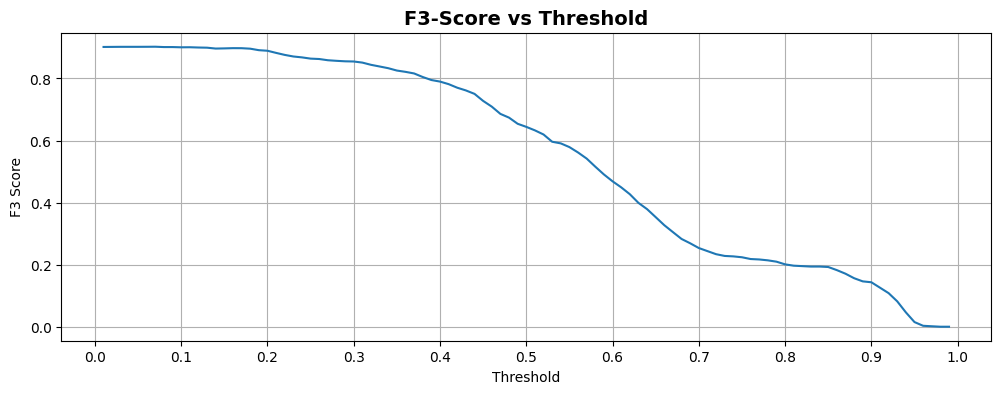

In [46]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_f3, x='Threshold', y='F3_Score')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()

# Tambahkan judul
plt.title('F3-Score vs Threshold', fontsize=14, fontweight='bold')
plt.xlabel('Threshold')
plt.ylabel('F3 Score')

plt.show()

**Insight utama:**

Threshold optimal 0.07 menunjukkan bahwa untuk memaksimalkan keberhasilan deteksi kasus positif (dengan fokus recall), model perlu dibuat longgar dalam memutuskan “positif”. Pendekatan ini sangat bermanfaat jika tujuan utamanya adalah meminimalkan jumlah kasus positif yang terlewat.

---
#### Confusion Matrix Logreg

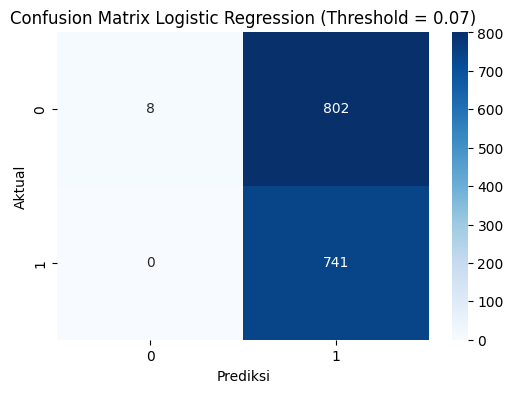

In [47]:
# Prediksi probabilitas churn (kelas 1)
y_pred_proba = pipe_logreg.predict_proba(X_test)[:, 1]

# Ubah ke prediksi kelas dengan threshold 0.07
threshold = 0.07
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title(f"Confusion Matrix Logistic Regression (Threshold = {threshold})")
plt.show()

- Biaya Campaign : 802 x 10$ = 8.020$
- Lost Opportunity : 0 x 150$ = 0$
- Total = 8.020$

---
## **Interpretation**

In [48]:
import statsmodels.api as sm


X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_train_add = sm.add_constant(X_train_encoded).astype(float)
y_train_num = y_train.astype(int)

logit = sm.Logit(y_train_num, X_train_add)
logit_fit = logit.fit()
print(logit_fit.summary())


Optimization terminated successfully.
         Current function value: 0.569310
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                 6200
Model:                          Logit   Df Residuals:                     6167
Method:                           MLE   Df Model:                           32
Date:                Sat, 16 Aug 2025   Pseudo R-squ.:                  0.1775
Time:                        20:49:35   Log-Likelihood:                -3529.7
converged:                       True   LL-Null:                       -4291.5
Covariance Type:            nonrobust   LLR p-value:                2.000e-300
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8640      0.231      3.737      0.000       0.411       1.317
age     

---
## Model Interpretation

### LLR P-Value

- **H₀:** Semua β = 0 → Semua fitur tidak berpengaruh signifikan terhadap target  
- **H₁:** Minimal satu β ≠ 0 → Minimal satu fitur berpengaruh signifikan terhadap target  

**LLR p-value** = `2.00e-300` → Sangat kecil → Tolak H₀ → Minimal satu fitur berpengaruh signifikan terhadap target.


### Wald Test P-Value (Per Fitur)

- **H₀:** β = 0 → Fitur tidak berpengaruh signifikan terhadap target  
- **H₁:** β ≠ 0 → Fitur berpengaruh signifikan terhadap target  

| Fitur               | p-value | Signifikansi | Interpretasi |
|---------------------|---------|--------------|--------------|
| const               | 0.000   | Signifikan | Intercept signifikan |
| age                 | 0.234   | Tidak signifikan | - |
| balance             | 0.000   | Signifikan | Semakin besar saldo, semakin besar peluang deposito |
| campaign            | 0.000   | Signifikan | Semakin banyak kontak Campaign, peluang deposit menurun |
| pdays               | 0.890   | Tidak signifikan | - |
| job_blue-collar     | 0.605   | Tidak signifikan | - |
| job_entrepreneur    | 0.183   | Tidak signifikan | - |
| job_housemaid       | 0.117   | Tidak signifikan | - |
| job_management      | 0.948   | Tidak signifikan | - |
| job_retired         | 0.001   | Signifikan | Pensiunan lebih berpeluang deposito |
| job_self-employed   | 0.340   | Tidak signifikan | - |
| job_services        | 0.372   | Tidak signifikan | - |
| job_student         | 0.004   | Signifikan | Peluang deposito lebih tinggi |
| job_technician      | 0.776   | Tidak signifikan | - |
| job_unemployed      | 0.253   | Tidak signifikan | - |
| housing_yes         | 0.000   | Signifikan | Memiliki kredit rumah menurunkan peluang deposito |
| loan_yes            | 0.000   | Signifikan | Memiliki pinjaman menurunkan peluang deposito |
| contact_telephone   | 0.002   | Signifikan | Negatif dibanding referensi (cellular) |
| contact_unknown     | 0.000   | Signifikan | Negatif dibanding referensi |
| month_aug           | 0.000   | Signifikan | Negatif dibanding referensi (April) |
| month_dec           | 0.004   | Signifikan | Positif dibanding referensi |
| month_feb           | 0.003   | Signifikan | Negatif |
| month_jan           | 0.000   | Signifikan | Negatif |
| month_jul           | 0.000   | Signifikan | Negatif |
| month_jun           | 0.276   | Tidak signifikan | - |
| month_mar           | 0.000   | Signifikan | Positif |
| month_may           | 0.000   | Signifikan | Negatif |
| month_nov           | 0.000   | Signifikan | Negatif |
| month_oct           | 0.000   | Signifikan | Positif |
| month_sep           | 0.002   | Signifikan | Positif |
| poutcome_other      | 0.079   | Tidak signifikan | - |
| poutcome_success    | 0.000   | Signifikan | Peluang deposito jauh lebih tinggi jika Campaign sebelumnya sukses |
| poutcome_unknown    | 0.872   | Tidak signifikan | - |


beberapa detail insight dari Odd Ratio :

In [49]:
# Odd Ratio campaign
Beta = -0.0755
c = 7
d = 6

OR_campaign = np.exp(Beta * (c-d)) # Odd Ratio
OR_campaign

np.float64(0.9272797305339988)

Insight:
Orang yang 7 kali ditelpon (campign = 7), resiko tidak deposito sebesar 0.927 kalinya dari orang yang 6 kali ditelpon (campign = 6)

In [50]:
# Odd Ratio job
Beta = 0.5167
OR_job_retired = np.exp(Beta)
OR_job_retired

np.float64(1.676486107029234)

Insight :
- Orang yang sudah pensiun, berpeluang 1.5167 kali untuk deposito dibanding yang masih bekerja ataupun pelajar.

In [51]:
# Odd Ratio housing_yes
Beta = -0.4912
OR_housing_yes = np.exp(Beta)
OR_housing_yes

np.float64(0.6118916834260151)

Insight :
- Orang yang punya pinjaman rumah, berpeluang 0.6118 kali untuk deposito dibanding yang tidak punya.

In [52]:
# Odd Ratio loan_yes
Beta = -0.4721
OR_loan_yes = np.exp(Beta)
OR_loan_yes

np.float64(0.6236911406851239)

Insight :
- Orang yang punya pinjaman, berpeluang 0.6236 kali untuk deposito dibanding yang tidak punya.

In [53]:
# Odd Ratio contact_telephone
Beta = -0.3777
OR_contact_telephone = np.exp(Beta)
OR_contact_telephone

np.float64(0.6854361006545264)

Insight :
- Orang yang dihubungi via telepon untuk penawaran campaign, berpeluang 0.6854 kali untuk deposito dibanding yang dihubungi dengan metode contact lainnya.

In [54]:
# Odd Ratio poutcome_success
Beta = 2.0188
OR_poutcome_success = np.exp(Beta)
OR_poutcome_success

np.float64(7.529284369165095)

Insight :
- Orang yang di campaign sebelumnya berhasil di berikan penawaran, berpeluang 7.5292 kali untuk deposito dibandingkan poutcome lainnya.

---
## Saving To Pickle

In [55]:
import pickle

**Define Pickle Model & Dumping to Pickle**

In [56]:
best_model = pipe_logreg

best_model.fit(X, y)

pickle.dump(best_model, open('model_best_model.sav','wb'))

In [57]:
model_loaded = pickle.load(open('model_best_model.sav', 'rb'))

model_loaded

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['job']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['month']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('robust', RobustScaler(),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays'])])),
                ('modeling',
                 LogisticRegression(class_weight='balanced', random_state=0))])

In [58]:
df.describe(include = 'all')

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
count,7751.000000,7751,7751.000000,7751,7751,7751,7751,7751.000000,7751.000000,7751,7751
unique,NaN,11,NaN,2,2,3,12,NaN,NaN,4,2
top,NaN,management,NaN,no,no,cellular,may,NaN,NaN,unknown,no
freq,NaN,1789,NaN,4084,6729,5587,1969,NaN,NaN,5771,4047
mean,41.210812,NaN,1510.083602,NaN,NaN,NaN,NaN,2.517095,51.453748,NaN,NaN
std,11.906602,NaN,3085.165104,NaN,NaN,NaN,NaN,2.724405,107.981876,NaN,NaN
min,18.000000,NaN,-6847.000000,NaN,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN
25%,32.000000,NaN,128.000000,NaN,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN
50%,39.000000,NaN,549.000000,NaN,NaN,NaN,NaN,2.000000,-1.000000,NaN,NaN
75%,49.000000,NaN,1684.500000,NaN,NaN,NaN,NaN,3.000000,40.500000,NaN,NaN


## Conclusion

## Analisis Biaya Setelah Menggunakan Machine Learning

**Asumsi Biaya**
- **Campaign cost (C)** = USD 10 / nasabah yang dihubungi  
- **Lost opportunity cost (L)** = USD 150 / nasabah potensial yang tidak dihubungi  


**Confusion Matrix Model (Threshold = 0.07)**

| Aktual \ Prediksi      | 0 (Tidak Deposito) | 1 (Deposito) |
| ---------------------- | -----------------: | -----------: |
| **0** (Tidak Deposito) |             TN = 8 |      FP = 802 |
| **1** (Deposito)       |             FN = 0 |      TP = 741 |

- **Total data** = 1,551  
- **Total aktual deposito (yes)** = 741  
- **Total aktual tidak deposito (no)** = 810  



**1. Campaign Cost**
- Jumlah nasabah yang dihubungi = **TP + FP = 741 + 802 = 1,543**  
- Biaya kampanye = **1,543 × USD 10 = USD 15,430**  



**2. Lost Opportunity Cost**
- Jumlah nasabah potensial yang tidak dihubungi = **FN = 0**  
- Biaya lost opportunity = **0 × USD 150 = USD 0**  



**3. Total Biaya dengan ML**
**Total biaya = USD 15,430 (kampanye) + USD 0 (lost opportunity) = USD 15,430**



**Perbandingan Biaya**

| Skenario                                        |   Total Biaya | Selisih dibanding ML |
| ----------------------------------------------- | ------------: | -------------------: |
| **Treat All** (hubungi semua; 1,551×C)          |  **USD 15,510** |       +80 (lebih mahal) |
| **Treat None** (tidak hubungi; 741×L)           | **USD 111,150** |  +95,720 (lebih mahal) |
| **Machine Learning (threshold = 0.07)**         |  **USD 15,430** |                    – |



**Kesimpulan**
Dengan threshold **0,07**, model ML menurunkan biaya total menjadi **USD 15,430**.  

- Lebih hemat **USD 80** dibandingkan strategi **Treat All**.  
- Jauh lebih hemat **USD 95,720** dibandingkan strategi **Treat None**.  
- Meskipun selisih dengan **Treat All** relatif kecil, model ML berhasil **menghilangkan kerugian akibat lost opportunity (FN = 0)** → lebih aman dan optimal dari sisi risiko bisnis.  

---

## Recommendation

Rekomendasi Strategi Campaign Berdasarkan Analisis Data :

1. **Pelanggan dengan riwayat kontak sebelumnya sukses → peluang deposito tinggi**  
   - Fokuskan kampanye ke nasabah dengan riwayat `poutcome = "success"` pada kontak sebelumnya.  
   - Berikan penawaran khusus atau follow-up cepat karena segmen ini cenderung merespon positif.

2. **Pelanggan yang dihubungi pada bulan tertentu (misalnya May, Aug) → peluang deposito tinggi**  
   - Jadwalkan kampanye besar pada bulan-bulan dengan tren respon tinggi.  
   - Optimalkan intensitas komunikasi di bulan ini untuk memaksimalkan konversi.

3. **Pelanggan dengan `pdays` rendah (baru dihubungi) → peluang deposito tinggi**  
   - Segera follow-up nasabah yang baru saja dihubungi, jangan menunggu terlalu lama.  
   - Gunakan multi-channel (telepon, email, SMS) dalam 1–3 hari setelah kontak awal.

4. **Pelanggan dengan `campaign` rendah (sedikit kontak) → peluang deposito tinggi**  
   - Hindari over-contact yang bisa membuat nasabah jenuh.  
   - Lakukan komunikasi singkat namun personal, cukup 1–2 kali untuk segmen ini.

5. **Pelanggan dengan saldo (`balance`) tinggi → peluang deposito tinggi**  
   - Berikan penawaran eksklusif atau bunga kompetitif untuk segmen saldo tinggi.  
   - Sertakan simulasi keuntungan deposito agar lebih menarik bagi segmen ini.

---
# **Generating A New Dataset From GPT**

In [59]:
# Generate A New Dataset From GPT


def normalize_probs(probs):
    probs = np.array(probs, dtype=float)
    return probs / probs.sum()

# Parameter dataset
n = 7751

# Kategori dan probabilitas (mentah)
job_categories = ["management", "technician", "entrepreneur", "blue-collar", "unknown",
                  "retired", "admin.", "services", "self-employed", "unemployed", "student"]
job_probs = normalize_probs([0.23, 0.15, 0.08, 0.12, 0.05, 0.10, 0.07, 0.05, 0.04, 0.03, 0.03])

housing_values = ["yes", "no"]
housing_probs = normalize_probs([0.47, 0.53])

loan_values = ["yes", "no"]
loan_probs = normalize_probs([0.13, 0.87])

contact_values = ["cellular", "telephone", "unknown"]
contact_probs = normalize_probs([0.72, 0.07, 0.21])

month_values = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
month_probs = normalize_probs([0.07, 0.06, 0.05, 0.06, 0.25, 0.08, 0.07, 0.09, 0.05, 0.08, 0.07, 0.07])

poutcome_values = ["success", "failure", "other", "unknown"]
poutcome_probs = normalize_probs([0.10, 0.15, 0.08, 0.67])

deposit_values = ["yes", "no"]
deposit_probs = normalize_probs([0.48, 0.52])

# Pembuatan dataset
data = {
    "age": np.random.randint(18, 96, size=n),
    "job": np.random.choice(job_categories, size=n, p=job_probs),
    "balance": np.random.normal(loc=1510.08, scale=3085.16, size=n).astype(int),
    "housing": np.random.choice(housing_values, size=n, p=housing_probs),
    "loan": np.random.choice(loan_values, size=n, p=loan_probs),
    "contact": np.random.choice(contact_values, size=n, p=contact_probs),
    "month": np.random.choice(month_values, size=n, p=month_probs),
    "campaign": np.random.randint(1, 64, size=n),
    "pdays": np.random.randint(-1, 855, size=n),
    "poutcome": np.random.choice(poutcome_values, size=n, p=poutcome_probs),
    "deposit": np.random.choice(deposit_values, size=n, p=deposit_probs)
}

df_new = pd.DataFrame(data)


## **Modeling With Pickle Saved Model**

In [60]:
df_new

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,48,admin.,2886,yes,no,cellular,may,42,203,unknown,yes
1,18,blue-collar,-2040,yes,yes,cellular,sep,54,125,unknown,yes
2,65,unemployed,4542,yes,no,cellular,may,61,726,unknown,no
3,73,management,-406,no,no,cellular,aug,31,319,unknown,no
4,34,self-employed,-2603,yes,no,cellular,jun,1,727,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...
7746,89,self-employed,391,no,no,unknown,jul,8,522,failure,no
7747,81,management,734,no,no,cellular,jul,44,403,other,no
7748,70,student,1203,no,yes,telephone,sep,20,143,unknown,no
7749,47,entrepreneur,7921,yes,no,unknown,may,18,421,unknown,yes


In [61]:
X = df_new.drop("deposit", axis=1)
y = df_new["deposit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
sample = X_test  # one sample row
pred = model_loaded.predict(sample)
pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1551,))